In [53]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities
from PIL import Image
import pandas as pd
seaborn.set()

In [32]:
model = tf.keras.models.load_model('../models/resnet50vggface2.h5')
model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("dim_proj").output)

In [46]:
mean = np.float32(np.array([91.4953, 103.8827, 131.0912]))
base = "/data/vggface/test_preprocessed_sampled"
identities = os.listdir(base)

id2vect = {x: [] for x in identities}

for identity in identities:
    with h5py.File(os.path.join(base, identity, "images.h5"), 'r') as f:
        images = np.float32(np.array([np.array(Image.fromarray(x).resize((224, 224))) for x in f['images'][:]]))
        images -= mean
        id2vect[identity] = l2_normalize(model.predict(images))

In [51]:
def roc_curve(id2vect):
    positive = []
    negative = []

    print("****** Computing pairwise distances *******")
    for identity in id2vect.keys():
        this_id_vectors = id2vect[identity]
        n_true = len(this_id_vectors)
        self_distances = pairwise_distances(
             this_id_vectors,
             this_id_vectors,
             metric='euclidean',
             n_jobs=4
        )
        # all distances below the diagonal compare every pair and exclude 0's to self
        self_dist_indices = np.tril_indices(n=n_true, k=-1)
        # this selection returns a flattened array of distances that are ground truth True
        self_distances = self_distances[self_dist_indices]
        positive.extend(self_distances)

        other_identities = list(set(identities) - set([identity]))
        negative_vectors = []
        seen = set()
        # to get roughly the same number of comparison as the base identity to itself,
        # which is n choose 2, we will compute (n_true - 2)/2 other vectors;
        # then, when we do pairwise comparisons between n and (n-2)/2 vectors,
        # we get exactly n choose 2 ground truth negative vectors
        while len(negative_vectors) < ((n_true - 2) // 2):
            other_id = np.random.choice(other_identities)

            other_embeddings = id2vect[other_id]

            embedding_index = np.random.choice(len(other_embeddings))
            if not ((other_id, embedding_index)) in seen:
                seen.add((other_id, embedding_index))
                negative_vectors.append(other_embeddings[embedding_index])

        negative_distances = pairwise_distances(
                 this_id_vectors,
                 negative_vectors,
                 metric='euclidean',
                 n_jobs=4
         )
        negative.extend(negative_distances.flatten())

    thresholds = np.arange(1e-6, 2.0, 0.1)
    tprs = []
    fprs = []
    n_pos = float(len(positive))
    n_neg = float(len(negative))

    print("**** Computing ROC curve *****")
    for t in thresholds:
        tp = np.sum(positive < t)
        fp = np.sum(negative < t)
        tprs.append(tp / n_pos)
        fprs.append(fp / n_neg)

    plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")
    plt.plot(fprs, tprs, label="ResNet50 VGGFace2")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve for model")

****** Computing pairwise distances *******
**** Computing ROC curve *****


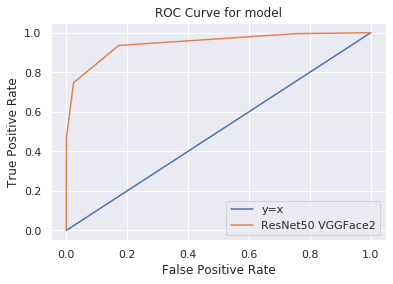

In [52]:
roc_curve(id2vect)

In [56]:
id2vect_raw = {}
bbox_df = pd.read_csv("/data/vggface/bb_landmark/loose_bb_test.csv")

sampled = read_sampled_identities("../sampled_identities.txt")
sampled = pd.DataFrame(np.array([["{}/{}".format(k, v.split(".")[0]) for v in sampled[k]] for k in sampled]).flatten())
# do a join to filter selected identities and frames
bbox_df = pd.merge(left=bbox_df, right=sampled, left_on='NAME_ID', right_on=0)

image_batch = []
for index, row in bbox_df.iterrows():
#         name_id, x, y, w, h, _ = row
    name_id, x, y, w, h = row
    current_identity = name_id.split('/')[0]
    x = max(x, 0)
    y = max(y, 0)
    # Read in the image
    image_path = os.path.join("/data/vggface/test", name_id + '.jpg')
    image = Image.open(image_path).crop((x, y, x + w, y + h)).resize(size=(224, 224))
    resized_image = np.array(image)
    
    image_batch.append(resized_image)
    # When we are done with a batch of images (one identity)...
    if index == len(bbox_df) - 1 or \
       current_identity != bbox_df.loc[index + 1, 'NAME_ID'].split('/')[0]:
        image_batch = np.stack(image_batch, axis=0)
        image_batch -= mean
        id2vect_raw[current_identity] = l2_normalize(model.predict(image_batch))
        image_batch = []

ValueError: too many values to unpack (expected 5)